In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

### Загрузка набора данных

Загрузка данных для обучения

In [ ]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv -O train.csv

--2021-05-29 15:25:46--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2021-05-29 15:25:46--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  95.6MB/s    in 0.3s    

2021-05-29 15:25:48 (95.6 MB/s) - ‘train.csv’ saved [29470338/29470338]



Загрузка данных для тестирования

In [ ]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv -O test.csv

--2021-05-29 15:26:57--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv [following]
--2021-05-29 15:26:57--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.77M  --.-KB/s    in 0.08s   

2021-05-29 15:26:57 (23.4 MB/s) - ‘test.csv’ saved [1857427/1857427]



Загрузка имен классов

In [ ]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt -O classes.txt

--2021-05-29 15:27:19--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2021-05-29 15:27:19 (2.46 MB/s) - ‘classes.txt’ saved [31/31]



In [ ]:
train = pd.read_csv('train.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [ ]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
news = train['text']

In [ ]:
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [ ]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### Токенизация текста

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучение токенизатора

In [ ]:
tokenizer.fit_on_texts(news)

Преобразование новостей в числое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(news)

Ограничение длины новости

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

### Сверточная нейронная сеть

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

In [ ]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 392,894
Trainable params: 392,894
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_cnn = model_cnn.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 26s 29ms/step - loss: 0.4354 - accuracy: 0.8446 - val_loss: 0.3061 - val_accuracy: 0.8904
Epoch 2/5
844/844 [==============================] - 25s 29ms/step - loss: 0.2488 - accuracy: 0.9153 - val_loss: 0.3203 - val_accuracy: 0.8845
Epoch 3/5
844/844 [==============================] - 25s 30ms/step - loss: 0.1956 - accuracy: 0.9314 - val_loss: 0.3401 - val_accuracy: 0.8837
Epoch 4/5
844/844 [==============================] - 25s 29ms/step - loss: 0.1451 - accuracy: 0.9488 - val_loss: 0.3756 - val_accuracy: 0.8813
Epoch 5/5
844/844 [==============================] - 25s 29ms/step - loss: 0.0958 - accuracy: 0.9672 - val_loss: 0.4502 - val_accuracy: 0.8732


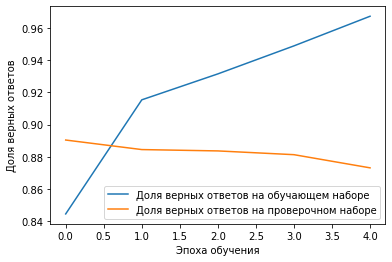

In [ ]:
plt.plot(history_cnn.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(4, activation='softmax'))

In [ ]:
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 323,204
Trainable params: 323,204
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 21s 22ms/step - loss: 0.5084 - accuracy: 0.8193 - val_loss: 0.3277 - val_accuracy: 0.8882
Epoch 2/5
844/844 [==============================] - 18s 22ms/step - loss: 0.2758 - accuracy: 0.9120 - val_loss: 0.3241 - val_accuracy: 0.8845
Epoch 3/5
844/844 [==============================] - 18s 22ms/step - loss: 0.2382 - accuracy: 0.9232 - val_loss: 0.3250 - val_accuracy: 0.8876
Epoch 4/5
844/844 [==============================] - 18s 22ms/step - loss: 0.2146 - accuracy: 0.9301 - val_loss: 0.3417 - val_accuracy: 0.8831
Epoch 5/5
844/844 [==============================] - 18s 22ms/step - loss: 0.1923 - accuracy: 0.9364 - val_loss: 0.3696 - val_accuracy: 0.8779


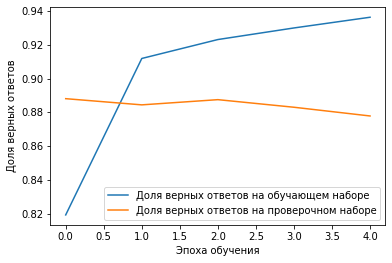

In [ ]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(4, activation='softmax'))

In [ ]:
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 322,468
Trainable params: 322,468
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru = model_gru.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 19s 23ms/step - loss: 0.1827 - accuracy: 0.9390 - val_loss: 0.3694 - val_accuracy: 0.8815
Epoch 2/5
844/844 [==============================] - 19s 23ms/step - loss: 0.1665 - accuracy: 0.9447 - val_loss: 0.3942 - val_accuracy: 0.8771
Epoch 3/5
844/844 [==============================] - 20s 24ms/step - loss: 0.1523 - accuracy: 0.9490 - val_loss: 0.4167 - val_accuracy: 0.8716
Epoch 4/5
844/844 [==============================] - 19s 23ms/step - loss: 0.1393 - accuracy: 0.9540 - val_loss: 0.4341 - val_accuracy: 0.8735
Epoch 5/5
844/844 [==============================] - 20s 23ms/step - loss: 0.1259 - accuracy: 0.9576 - val_loss: 0.4790 - val_accuracy: 0.8654


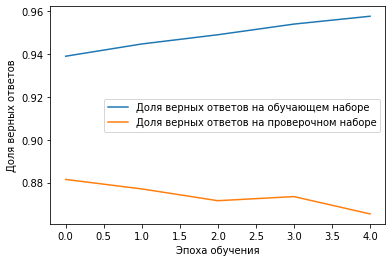

In [ ]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Тестовый набор

In [ ]:
test = pd.read_csv('test.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [ ]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

### Оценка качества сетей

Одномерная сверточная сеть

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 3ms/step - loss: 0.4449 - accuracy: 0.8857


[0.4449223279953003, 0.8856579065322876]

Сеть LSTM

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 4ms/step - loss: 0.3605 - accuracy: 0.8855


[0.36054474115371704, 0.8855262994766235]

Сеть GRU

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)

238/238 [==============================] - 1s 4ms/step - loss: 0.4549 - accuracy: 0.8761


[0.4549204111099243, 0.8760526180267334]